In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(train_set, batch_size=128, shuffle=True)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(test_set, batch_size=128, shuffle=True)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
class VAE(nn.Module):
  def __init__(self,input_size):
    super(VAE, self).__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(input_size,64,kernel_size=5,stride = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2),
        nn.Conv2d(64,64,kernel_size=3,stride = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2),
        nn.Conv2d(64,32,kernel_size=3,stride = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2),
        nn.Flatten(),
        nn.Linear(32,16)
    )
    self.distribution_mean = nn.Linear(16,2)
    self.distribution_log_var = nn.Linear(16,2)
    self.decoder = nn.Sequential(
        nn.Linear(2,64),
        nn.Unflatten(1,(64,1,1)),
        nn.ConvTranspose2d(64,64,kernel_size=3,stride=1),
        nn.ReLU(),
        nn.ConvTranspose2d(64,64,kernel_size=3,stride=1),
        nn.ReLU(),
        nn.UpsamplingNearest2d(scale_factor=2),
        nn.ConvTranspose2d(64,64,kernel_size=3,stride=1),
        nn.ReLU(),
        nn.UpsamplingNearest2d(scale_factor=2),
        nn.ConvTranspose2d(64,1,kernel_size=5,stride=1),
        nn.Sigmoid() # Added Sigmoid activation here
    )
  def encode(self,x):
      x = self.encoder(x)
      mean = self.distribution_mean(x)
      log_var = self.distribution_log_var(x)
      return mean,log_var

  def reparametrization(self,mean,log_var):
      std = torch.exp(0.5 * log_var)
      epsilon = torch.randn_like(std).to(device)
      return mean + std*epsilon

  def decode(self,z):
      z = self.decoder(z)
      return z
  def forward(self,x):
      mean,log_var = self.encode(x)
      z = self.reparametrization(mean,log_var)
      x = self.decode(z)
      return x,mean,log_var

In [ ]:
model = VAE(1).to(device)
optimizer = optim.Adam(model.parameters(),lr = 1e-3)

In [ ]:
def loss_function(x,x_hat,mean,log_var):
  reconstruction_loss = F.binary_cross_entropy(x_hat,x,reduction='sum')
  kl_loss = 0.5 * torch.sum(mean**2 + log_var.exp() - 1 - log_var)
  return reconstruction_loss + kl_loss

In [ ]:
def train(model, optimizer, epochs, device):
    model.train()
    history = []
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(trainloader):

            x = x.to(device)
            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        avg_loss = overall_loss/len(trainloader)
        history.append(avg_loss)


        print("\tEpoch", epoch + 1, "\tAverage Loss: ", avg_loss)
    return history

train_loss = train(model, optimizer, epochs=100, device=device)

	Epoch 1 	Average Loss:  25667.17289528918
	Epoch 2 	Average Loss:  21218.630788579423
	Epoch 3 	Average Loss:  20554.872459688166
	Epoch 4 	Average Loss:  20237.599667677237
	Epoch 5 	Average Loss:  20021.922545475747
	Epoch 6 	Average Loss:  19837.787459188432
	Epoch 7 	Average Loss:  19697.294871901653
	Epoch 8 	Average Loss:  19617.890887360074
	Epoch 9 	Average Loss:  19518.74275178238
	Epoch 10 	Average Loss:  19429.159775203225
	Epoch 11 	Average Loss:  19355.93694404651
	Epoch 12 	Average Loss:  19316.15681220016
	Epoch 13 	Average Loss:  19245.075801239338
	Epoch 14 	Average Loss:  19198.901065265192
	Epoch 15 	Average Loss:  19171.208064032515
	Epoch 16 	Average Loss:  19122.65010952492
	Epoch 17 	Average Loss:  19081.414056253332
	Epoch 18 	Average Loss:  19043.620918843284
	Epoch 19 	Average Loss:  19029.318459321694
	Epoch 20 	Average Loss:  18982.249870902186
	Epoch 21 	Average Loss:  18957.850161164046
	Epoch 22 	Average Loss:  18927.283071944963
	Epoch 23 	Average Loss:

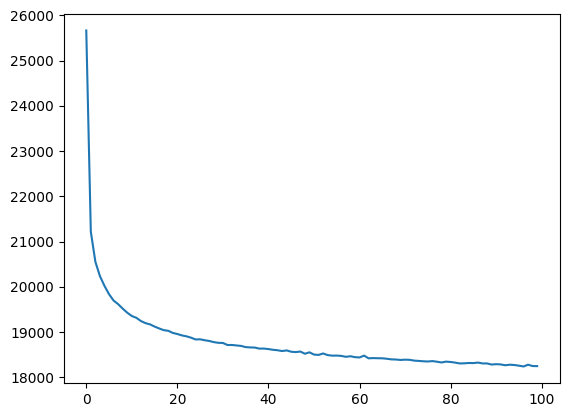

In [ ]:
plt.plot(train_loss)

In [ ]:
def interpolate(x1,x2):
    alpha = torch.linspace(0,1,9)
    return torch.stack([(1-a) * x1 + a * x2 for a in alpha])

def get_latent_variable(model, img):
    mean, log_var = model.encode(img)
    epsilon = torch.randn_like(log_var)
    z = mean + torch.exp(0.5 * log_var) * epsilon
    return z.squeeze(0)

In [ ]:
def visual_representation_of_same_digits(model,test_images,test_labels):
    model.eval()
    rows=[]
    for i in range(10):
        while 1:
            idx1 , idx2 = np.random.randint(0,len(test_images),2)

            if test_labels[idx1] == test_labels[idx2] :
                break
        img1,img2 = test_images[idx1].unsqueeze(0).to(device), test_images[idx2].unsqueeze(0).to(device)

        z1 = get_latent_variable(model,img1)
        z2 = get_latent_variable(model,img2)

        interpolates = interpolate(z1,z2)
        reconstructed = model.decode(interpolates).cpu().detach()
        rows.append(reconstructed)
    fig, axes = plt.subplots(10, 9, figsize=(12, 12))
    for i, row in enumerate(rows):
        for j, img in enumerate(row):
            axes[i, j].imshow(img.squeeze(), cmap="gray")
            axes[i, j].axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
def visual_representation_of_not_same_digits(model,test_images,test_labels):
    model.eval()
    rows=[]
    for i in range(10):
        while 1:
            idx1 , idx2 = np.random.randint(0,len(test_images),2)

            if test_labels[idx1] != test_labels[idx2] :
                break
        img1,img2 = test_images[idx1].unsqueeze(0).to(device), test_images[idx2].unsqueeze(0).to(device)

        z1 = get_latent_variable(model,img1)
        z2 = get_latent_variable(model,img2)

        interpolates = interpolate(z1,z2)
        reconstructed = model.decode(interpolates).cpu().detach()
        rows.append(reconstructed)
    fig, axes = plt.subplots(10, 9, figsize=(12, 12))
    for i, row in enumerate(rows):
        for j, img in enumerate(row):
            axes[i, j].imshow(img.squeeze(), cmap="gray")
            axes[i, j].axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
test_images = test_set.data.unsqueeze(1).float()/255  # shape [10000, 1, 28, 28]
test_labels = test_set.targets
print(test_images.shape)

torch.Size([10000, 1, 28, 28])


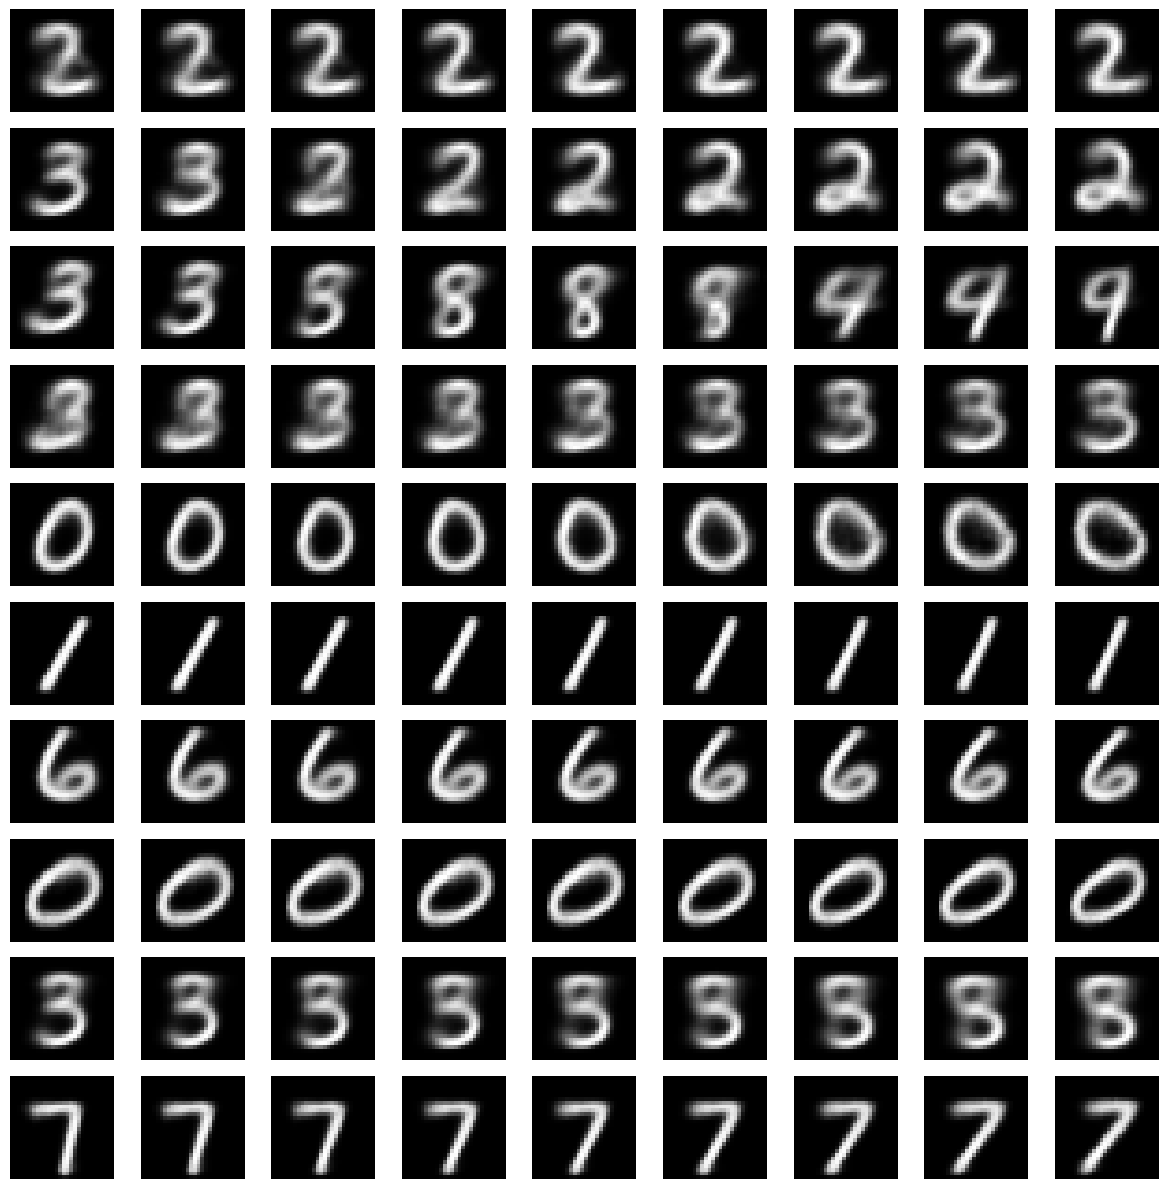

In [ ]:
visual_representation_of_same_digits(model,test_images,test_labels)

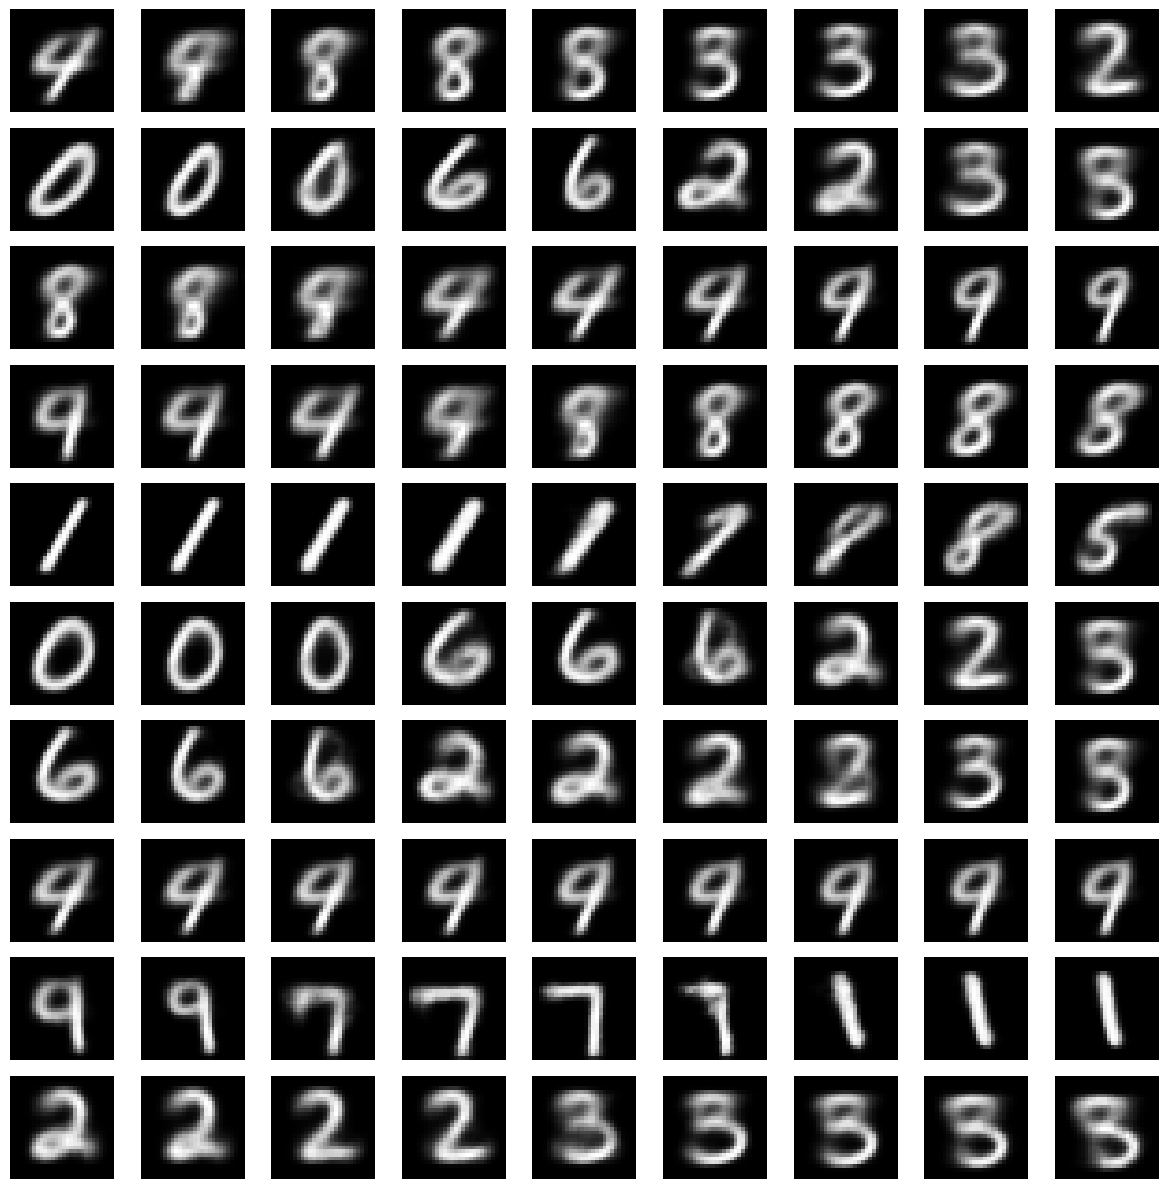

In [ ]:
visual_representation_of_not_same_digits(model,test_images,test_labels)